<a href="https://colab.research.google.com/github/prabal5ghosh/research-project-on-physics-informed-machine-learning-on-transcriptomics-data/blob/main/pinn_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers
import keras
from keras import layers

print(tf.__version__)
print(keras.__version__)


In [42]:
import torch
import torch.nn as nn

class ODENet(nn.Module):
    def __init__(self):
        super(ODENet, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(1, 32),
            nn.Tanh(),
            nn.Linear(32, 32),
            nn.Tanh(),
            nn.Linear(32, 5)  # Output layer with 5 neurons
        )

    def forward(self, t):
        return self.net(t)


In [43]:
def ode_loss(model, t, y_true):
    y_pred = model(t)

    # Reshape y_pred and y_true to have the same shape
    y_pred = y_pred.transpose(0, 1)  # Transpose to shape (5, 3)

    # Data loss
    loss_data = torch.mean((y_pred - y_true)**2)

    # Physics loss (approximating derivatives)
    dt = 0.01
    t_prev = t - dt
    t_next = t + dt
    y_prev = model(t_prev)
    y_next = model(t_next)
    dy_dt = (y_next - y_prev) / (2 * dt)

    # Define your ODE here (example: dy/dt = -y)
    # NOTE: You may need to adjust this part to match your actual ODE
    ode_residual = dy_dt + y_pred.transpose(0, 1)  # Transpose back for physics loss calculation
    loss_physics = torch.mean(ode_residual**2)

    return loss_data + loss_physics

In [45]:
import numpy as np

# Prepare data
data = np.array([
    [0.906000416, 0.906000416, 0.906000416],
    [-0.44796003, -0.560154646, -5.091964284],
    [1.778358524, 0, 0],
    [0, 1.175149691, 0],
    [0.055374646, 0.098434984, -0.101756864]
])
t_data = torch.tensor([1, 2, 4], dtype=torch.float32).unsqueeze(1)
y_data = torch.tensor(data, dtype=torch.float32)

model = ODENet()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

for epoch in range(10000):
    optimizer.zero_grad()
    loss = ode_loss(model, t_data, y_data)
    loss.backward()
    optimizer.step()

    if epoch % 1000 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item()}")


Epoch 0, Loss: 2.4126851558685303
Epoch 1000, Loss: 0.00014874956104904413
Epoch 2000, Loss: 1.2984169295293668e-08
Epoch 3000, Loss: 7.780156074943534e-09
Epoch 4000, Loss: 0.0001210949121741578
Epoch 5000, Loss: 1.0419543627904204e-07
Epoch 6000, Loss: 1.0432070496335655e-07
Epoch 7000, Loss: 7.738082103969646e-07
Epoch 8000, Loss: 1.1179724879184505e-06
Epoch 9000, Loss: 8.480400310872938e-07


In [46]:
y_data[1, :].detach().numpy()

array([-0.44796002, -0.5601546 , -5.0919642 ], dtype=float32)

(array([[1.],
       [2.],
       [4.]], dtype=float32), tensor([0.9060, 0.9060, 0.9060]))
(array([[1.],
       [2.],
       [4.]], dtype=float32), tensor([-0.4480, -0.5602, -5.0920]))
(array([[1.],
       [2.],
       [4.]], dtype=float32), tensor([1.7784, 0.0000, 0.0000]))
(array([[1.],
       [2.],
       [4.]], dtype=float32), tensor([0.0000, 1.1751, 0.0000]))
(array([[1.],
       [2.],
       [4.]], dtype=float32), tensor([ 0.0554,  0.0984, -0.1018]))


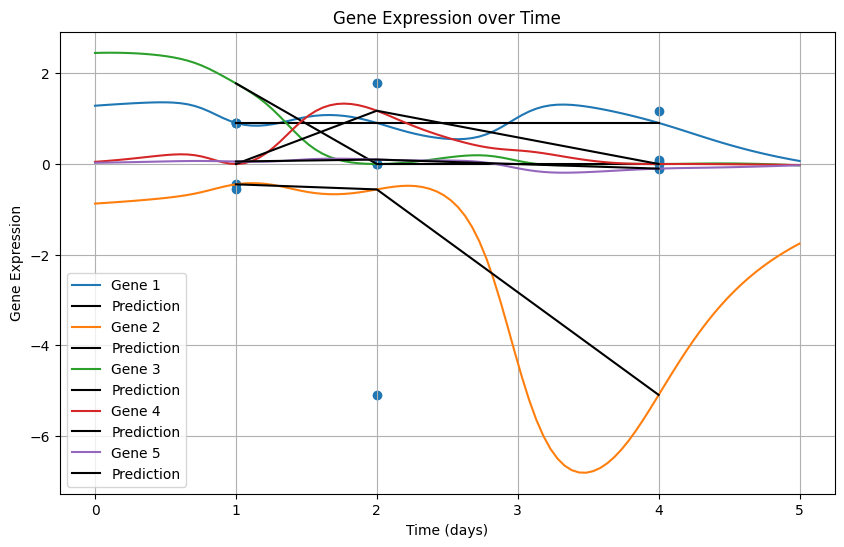

In [60]:
import matplotlib.pyplot as plt

t_plot = torch.linspace(0, 5, 100).unsqueeze(1)
y_plot = model(t_plot).detach().numpy()

plt.figure(figsize=(10, 6))
for i in range(5):
    plt.plot(t_plot, y_plot[:, i], label=f"Gene {i+1}")
    print((t_data.detach().numpy(), y_data[i, ]))
    plt.plot(t_data.detach().numpy(), y_data[i, ].detach().numpy(), label='Prediction', color='black')


# Repeat t_data for each gene and flatten y_data
t_scatter = np.repeat(t_data.numpy().squeeze(), y_data.shape[0])
y_scatter = y_data.numpy().flatten()
# plt.plot(t_data, y_data, label='Prediction', color='blue')


plt.scatter(t_scatter, y_scatter)  # Updated scatter plot
plt.xlabel("Time (days)")
plt.ylabel("Gene Expression")
plt.legend()
plt.title("Gene Expression over Time")
plt.grid(True)
plt.show()

In [ ]:
import tensorflow as tf
import numpy as np

# Data
time_points = np.array([1, 2, 4], dtype=np.float32).reshape(-1, 1)  # Time in days
expression_values = np.array([0.906000416, 0.906000416, 0.906000416], dtype=np.float32).reshape(-1, 1)

# Define the PINN model
class ODE_PINN(tf.keras.Model):
    def __init__(self):
        super(ODE_PINN, self).__init__()
        self.hidden_layers = [tf.keras.layers.Dense(50, activation='tanh') for _ in range(5)]
        self.output_layer = tf.keras.layers.Dense(1)  # Predict x(t)
        self.k = tf.Variable(0.1, trainable=True, dtype=tf.float32)  # Learnable parameter k

    def call(self, t):
        x = t
        for layer in self.hidden_layers:
            x = layer(x)
        return self.output_layer(x)

# Define loss function
def loss_fn(model, t, x_true):
    t = tf.convert_to_tensor(t)  # Convert t to a TensorFlow tensor
    x_pred = model(t)  # Predicted x(t)
    with tf.GradientTape() as tape:
        tape.watch(t)
        x_t = model(t)
    dx_dt = tape.gradient(x_t, t)  # Compute dx/dt
    k = model.k
    x_steady = tf.constant(0.906, dtype=tf.float32)  # Assuming steady-state value
    ode_residual = dx_dt + k * (x_t - x_steady)
    return tf.reduce_mean(tf.square(ode_residual)) + tf.reduce_mean(tf.square(x_pred - x_true))


# Prepare training
model = ODE_PINN()
optimizer = tf.optimizers.Adam()

# Training loop
epochs = 1000
for epoch in range(epochs):
    with tf.GradientTape() as tape:
        loss = loss_fn(model, time_points, expression_values)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    if epoch % 100 == 0:
        print(f"Epoch {epoch}, Loss: {loss.numpy()}")

# Display the learned parameter k
print(f"Learned decay constant k: {model.k.numpy()}")

# Predict x(t) using the trained PINN
predicted_values = model(time_points)
print("Predicted Values:", predicted_values.numpy())


Epoch 0, Loss: 1.9628865718841553
Epoch 100, Loss: 0.0006397541146725416
Epoch 200, Loss: 6.584434595424682e-05
Epoch 300, Loss: 3.8334888813551515e-05
Epoch 400, Loss: 2.187471545767039e-05
Epoch 500, Loss: 1.2387660717649851e-05
Epoch 600, Loss: 7.572311005787924e-06
Epoch 700, Loss: 5.394518666435033e-06
Epoch 800, Loss: 4.492435891734203e-06
Epoch 900, Loss: 4.123608960071579e-06
Learned decay constant k: 0.10000000149011612
Predicted Values: [[0.90747964]
 [0.90344304]
 [0.90709406]]


In [ ]:
import tensorflow as tf
import numpy as np

# Data
time_points = np.array([1, 2, 4], dtype=np.float32).reshape(-1, 1)  # Time in days
expression_values = np.array([
    [0.906000416, 0.906000416, 0.906000416],    # AT2G38470
    [-0.44796003, -0.560154646, -5.091964284],  # AT5G40100
    [1.778358524, 0, 0],                        # AT1G06930
    [0, 1.175149691, 0],                        # AT1G04470
    [0.055374646, 0.098434984, -0.101756864],   # AT5G66730
    [0.505, 0.505, 0.505],                      # AT2G38471
], dtype=np.float32)

# Number of genes
num_genes = expression_values.shape[0]

# Define the PINN model for multiple genes
class MultiGeneODE_PINN(tf.keras.Model):
    def __init__(self, num_genes):
        super(MultiGeneODE_PINN, self).__init__()
        self.num_genes = num_genes
        self.hidden_layers = [tf.keras.layers.Dense(50, activation='tanh') for _ in range(5)]
        self.output_layer = tf.keras.layers.Dense(num_genes)  # Predict x(t) for all genes
        self.k = tf.Variable(tf.random.uniform([num_genes], 0.1, 1.0), trainable=True, dtype=tf.float32)  # Learnable parameters k for each gene

    def call(self, t):
        x = t
        for layer in self.hidden_layers:
            x = layer(x)
        return self.output_layer(x)

# Define loss function
def loss_fn(model, t, x_true):
    t = tf.convert_to_tensor(t, dtype=tf.float32)  # Ensure t is a TensorFlow tensor
    x_pred = model(t)  # Predicted x(t) for all genes

    with tf.GradientTape() as tape:
        tape.watch(t)
        x_t = model(t)  # Recompute x(t) under the tape
    dx_dt = tape.gradient(x_t, t)  # Compute dx/dt for all genes

    k = tf.expand_dims(model.k, axis=0)  # Expand dims to match batch size
    x_steady = tf.constant(expression_values[:, -1], dtype=tf.float32)  # Steady-state values from the last time point
    x_steady = tf.expand_dims(x_steady, axis=0)  # Expand dims to match batch size

    ode_residual = dx_dt + k * (x_t - x_steady)  # Residual for each gene

    # Combined loss: ODE residual + Data fitting
    return tf.reduce_mean(tf.square(ode_residual)) + tf.reduce_mean(tf.square(x_pred - x_true))

# Prepare training
model = MultiGeneODE_PINN(num_genes=num_genes)
optimizer = tf.optimizers.Adam(learning_rate=0.01)

# Training loop
epochs = 300
for epoch in range(epochs):
    with tf.GradientTape() as tape:
        loss = loss_fn(model, time_points, expression_values.T)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    if epoch % 100 == 0:
        print(f"Epoch {epoch}, Loss: {loss.numpy()}")

# Display the learned parameters k
print(f"Learned decay constants k: {model.k.numpy()}")

# Predict x(t) using the trained PINN
predicted_values = model(time_points).numpy()
print("Predicted Values:\n", predicted_values)


Epoch 0, Loss: 3.262493133544922
Epoch 100, Loss: 0.40018343925476074
Epoch 200, Loss: 0.3948259949684143
Learned decay constants k: [0.58500123 0.5124133  0.8344366  0.5212426  0.7251367  0.6896312 ]
Predicted Values:
 [[ 1.2032522e+00 -1.1358970e+00  1.3821652e+00  2.8010258e-01
   3.2409737e-01  8.2261866e-01]
 [ 1.1468748e+00 -1.2792391e+00  2.7368844e-01  1.1502681e+00
   2.9342303e-01  7.6453888e-01]
 [ 9.0583354e-01 -5.0920839e+00 -1.6356260e-04 -2.4212524e-04
  -1.0198407e-01  5.0472075e-01]]


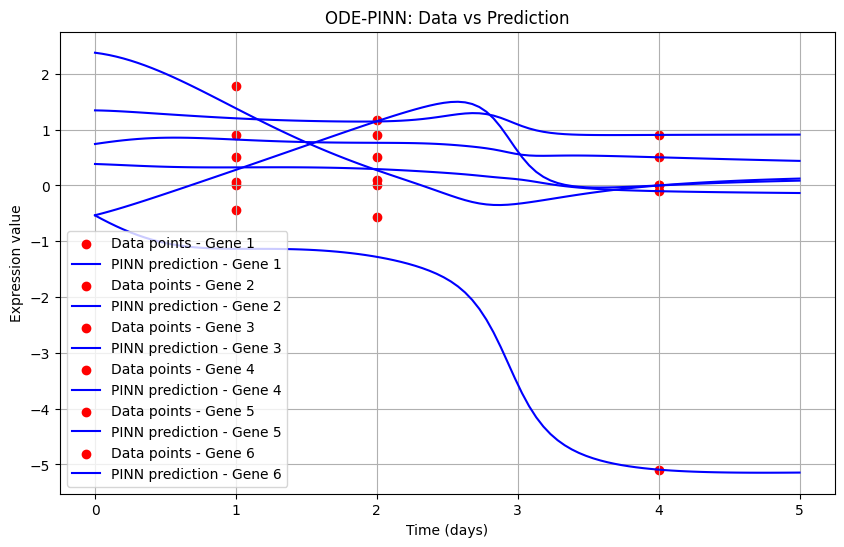

In [ ]:
import matplotlib.pyplot as plt

# Generate a range of time points for smooth curve
t_smooth = np.linspace(0, 5, 100).reshape(-1, 1)

# Get predictions for the smooth curve
x_smooth = model(t_smooth).numpy()

# Plot
plt.figure(figsize=(10, 6))

# Loop through each gene and plot its data and prediction
for i in range(num_genes):
    plt.scatter(time_points, expression_values[i], color='red', label=f'Data points - Gene {i+1}')
    plt.plot(t_smooth, x_smooth[:, i], color='blue', label=f'PINN prediction - Gene {i+1}')

plt.xlabel('Time (days)')
plt.ylabel('Expression value')
plt.title('ODE-PINN: Data vs Prediction')
plt.legend()
plt.grid(True)

plt.show()

Test Predictions (Predicted):
[[ 1.2032522e+00 -1.1358970e+00  1.3821652e+00  2.8010258e-01
   3.2409737e-01  8.2261866e-01]
 [ 1.1468748e+00 -1.2792391e+00  2.7368844e-01  1.1502681e+00
   2.9342303e-01  7.6453888e-01]
 [ 9.0583354e-01 -5.0920839e+00 -1.6356260e-04 -2.4212524e-04
  -1.0198407e-01  5.0472075e-01]]

Test Data (Actual):
[[0.9 0.7 0. ]
 [0.5 0.7 0.5]
 [0.  0.7 0. ]]


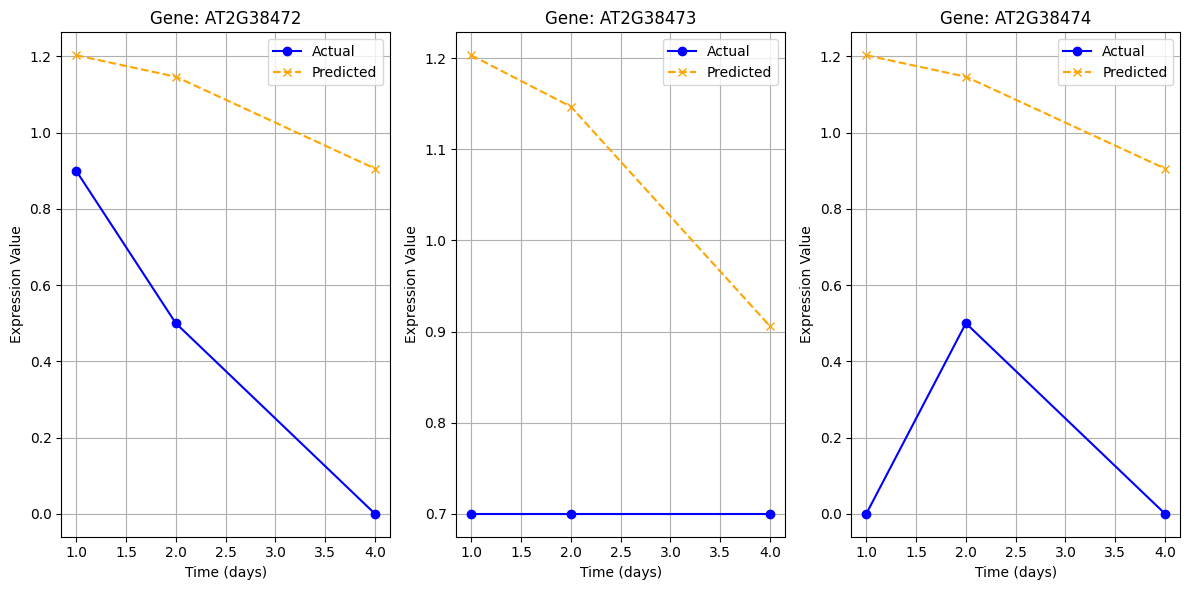

In [ ]:
import matplotlib.pyplot as plt

# Test data
test_expression_values = np.array([
    [0.9, 0.5, 0.0],  # AT2G38472
    [0.7, 0.7, 0.7],  # AT2G38473
    [0.0, 0.5, 0.0],  # AT2G38474
], dtype=np.float32)

# Predict x(t) for the test data using the trained PINN
test_time_points = np.array([1, 2, 4], dtype=np.float32).reshape(-1, 1)
predicted_test_values = model(test_time_points).numpy()


# Print the test predictions
print("Test Predictions (Predicted):")
print(predicted_test_values)

print("\nTest Data (Actual):")
print(test_expression_values.T)  # Transpose for direct comparison



# Plot predictions vs. actual data
gene_labels = ["AT2G38472", "AT2G38473", "AT2G38474"]

plt.figure(figsize=(12, 6))

for i, gene in enumerate(gene_labels):
    plt.subplot(1, 3, i + 1)  # Create subplots for each gene
    plt.plot(test_time_points, test_expression_values[i], 'o-', label="Actual", color="blue")
    plt.plot(test_time_points, predicted_test_values[:, 0], 'x--', label="Predicted", color="orange")
    plt.title(f"Gene: {gene}")
    plt.xlabel("Time (days)")
    plt.ylabel("Expression Value")
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()


In [ ]:
# import torch
# import torch.nn as nn
# import torch.optim as optim
# import numpy as np
# import scipy.io
# import time
# import torch.autograd as autograd  # This import was missing

# # Set the default dtype to float32
# torch.set_default_dtype(torch.float)

# # Set device configuration
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# print(device)

# if device == 'cuda':
#     print(torch.cuda.get_device_name())

# # ODE Constants
# lambda1 = 2.0
# lambda2 = 0.2

# # Data (Time dependent)
# data = {
#     'AT2G38470': [0.906000416, 0.906000416, 0.906000416]  # example data
# }

# # Time variable
# t = np.linspace(0, 1, 100)  # Example time points

# # Define the ODE function (for example purposes, we use a simple ODE form)
# def ode(t, u, lambda1, lambda2):
#     return lambda1 * u - lambda2 * u ** 2

# # Define the neural network for the inverse PINN
# class DNN(nn.Module):
#     def __init__(self, layers):
#         super(DNN, self).__init__()
#         self.activation = nn.Tanh()
#         self.linears = nn.ModuleList([nn.Linear(layers[i], layers[i+1]) for i in range(len(layers)-1)])

#         for i in range(len(layers)-1):
#             nn.init.xavier_normal_(self.linears[i].weight.data, gain=1.0)
#             nn.init.zeros_(self.linears[i].bias.data)

#     def forward(self, x):
#         a = x
#         for i in range(len(self.linears)-1):
#             z = self.linears[i](a)
#             a = self.activation(z)
#         a = self.linears[-1](a)
#         return a

# # Inverse PINN Class
# class PINN:
#     def __init__(self, layers):
#         self.loss_function = nn.MSELoss(reduction='mean')
#         self.lambda1 = torch.tensor([lambda1], requires_grad=True).float().to(device)
#         self.lambda2 = torch.tensor([lambda2], requires_grad=True).float().to(device)
#         self.dnn = DNN(layers).to(device)

#     def loss_data(self, t, u_data):
#         u_pred = self.dnn(t)
#         loss_u = self.loss_function(u_pred, u_data)
#         return loss_u

#     def loss_ODE(self, t):
#         u = self.dnn(t)
#         u_t = autograd.grad(u, t, torch.ones(t.shape).to(device), retain_graph=True)[0]

#         f = u_t - (self.lambda1 * u - self.lambda2 * u ** 2)
#         loss_ODE = self.loss_function(f, torch.zeros_like(f))
#         return loss_ODE

#     def loss(self, t, u_data):
#         loss_u = self.loss_data(t, u_data)
#         loss_ODE = self.loss_ODE(t)
#         return loss_u + loss_ODE

#     def closure(self):
#         optimizer.zero_grad()
#         loss = self.loss(t_train, u_train)
#         loss.backward()
#         return loss

#     def test(self, t_true, u_true):
#         u_pred = self.dnn(t_true)
#         error = torch.linalg.norm(u_true - u_pred, 2) / torch.linalg.norm(u_true, 2)
#         return error, u_pred

# # Initialize PINN
# layers = [1, 20, 20, 20, 1]  # Example architecture: 1 input (time), 1 output (solution)
# pinn = PINN(layers)

# # Optimizer (L-BFGS)
# optimizer = torch.optim.LBFGS(list(pinn.dnn.parameters()) + [pinn.lambda1, pinn.lambda2], lr=1e-1)

# # Create training data tensors and move to device
# t_train = torch.from_numpy(t).float().to(device).unsqueeze(1)
# # Enable gradient tracking for t_train
# t_train.requires_grad = True
# u_train = torch.tensor([data['AT2G38470'][0]] * len(t), dtype=torch.float32).to(device)


# # Train the model
# start_time = time.time()
# optimizer.step(pinn.closure)
# elapsed = time.time() - start_time
# print(f'Training time: {elapsed:.2f} seconds')

# # Test the model
# t_true = torch.from_numpy(t).float().to(device).unsqueeze(1)
# # Enable gradient tracking for t_true as well
# t_true.requires_grad = True
# u_true = torch.tensor([data['AT2G38470'][0]] * len(t), dtype=torch.float32).to(device)  # True solution
# error, u_pred = pinn.test(t_true, u_true)

# print(f'Test error: {error.item():.5f}')

Epoch 0, Loss: 8.538158
Epoch 500, Loss: 0.000001
Epoch 1000, Loss: 0.000000
Epoch 1500, Loss: 0.000000
Epoch 2000, Loss: 0.000000
Epoch 2500, Loss: 0.003376
Epoch 3000, Loss: 0.000000
Epoch 3500, Loss: 0.000000
Epoch 4000, Loss: 0.000001
Epoch 4500, Loss: 0.000000
Estimated parameters:
k: -0.197881, c: -0.137929


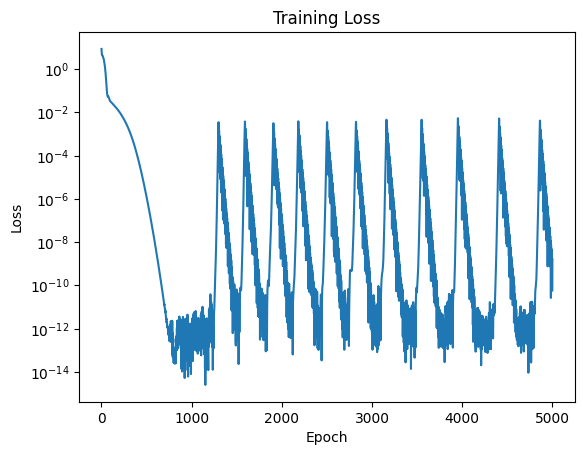

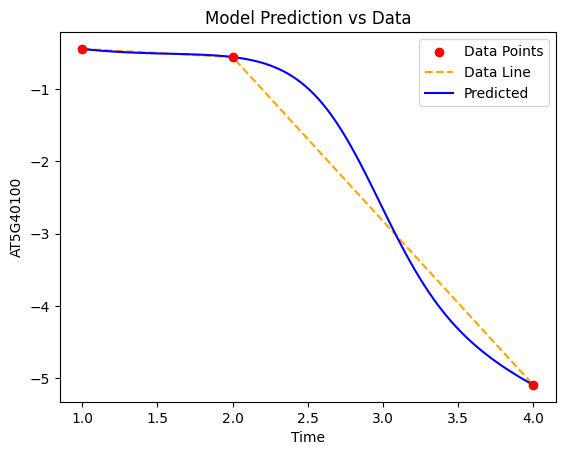

In [ ]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

# Given data
time_points = torch.tensor([1.0, 2.0, 4.0], dtype=torch.float32).view(-1, 1)
data_values = torch.tensor([-0.44796, -0.56015, -5.09196], dtype=torch.float32).view(-1, 1)

# Neural Network for PINN
class PINN(nn.Module):
    def __init__(self):
        super(PINN, self).__init__()
        self.hidden = nn.Sequential(
            nn.Linear(1, 20),
            nn.Tanh(),
            nn.Linear(20, 20),
            nn.Tanh(),
            nn.Linear(20, 1)
        )
        # Parameters to estimate
        self.k = nn.Parameter(torch.tensor(0.1, requires_grad=True))
        self.c = nn.Parameter(torch.tensor(0.1, requires_grad=True))

    def forward(self, t):
        return self.hidden(t)

# Physics-Informed Loss Function
def loss_function(model, t, y_true):
    # Data loss
    y_pred = model(t)
    data_loss = torch.mean((y_pred - y_true) ** 2)

    # Physics loss
    # y_pred.requires_grad = True
    t = t.clone().requires_grad_(True)
    y_pred = model(t)
    dy_dt = torch.autograd.grad(y_pred, t, grad_outputs=torch.ones_like(y_pred), create_graph=True)[0]
    physics_loss = torch.mean((dy_dt + model.k * y_pred - model.c) ** 2)
    return data_loss + physics_loss

# Model, Optimizer, and Training Setup
model = PINN()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Training loop
num_epochs = 5000
loss_history = []
for epoch in range(num_epochs):
    optimizer.zero_grad()
    loss = loss_function(model, time_points, data_values)
    loss.backward()
    optimizer.step()

    loss_history.append(loss.item())
    if epoch % 500 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.6f}")

# Results
print("Estimated parameters:")
print(f"k: {model.k.item():.6f}, c: {model.c.item():.6f}")

# Plot Loss History
plt.plot(loss_history)
plt.yscale('log')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()

# Plot Prediction vs Data
# Plot given data points
plt.scatter(time_points.numpy(), data_values.numpy(), label='Data Points', color='red', zorder=5)
plt.plot(time_points.numpy(), data_values.numpy(), label='Data Line', color='orange', linestyle='--')

# Plot model prediction
t_fine = torch.linspace(1, 4, 100).view(-1, 1)
y_pred_fine = model(t_fine).detach().numpy()
plt.plot(t_fine.numpy(), y_pred_fine, label='Predicted', color='blue')

plt.xlabel('Time')
plt.ylabel('AT5G40100')
plt.title('Model Prediction vs Data')
plt.legend()
plt.show()


Epoch 0, Loss: 0.051316
Epoch 500, Loss: 0.000006
Epoch 1000, Loss: 0.000000
Epoch 1500, Loss: 0.000000
Epoch 2000, Loss: 0.000073
Epoch 2500, Loss: 0.000009
Epoch 3000, Loss: 0.000000
Epoch 3500, Loss: 0.000000
Epoch 4000, Loss: 0.000000
Epoch 4500, Loss: 0.000003
Estimated parameters:
k: -0.397690, c: -0.128836


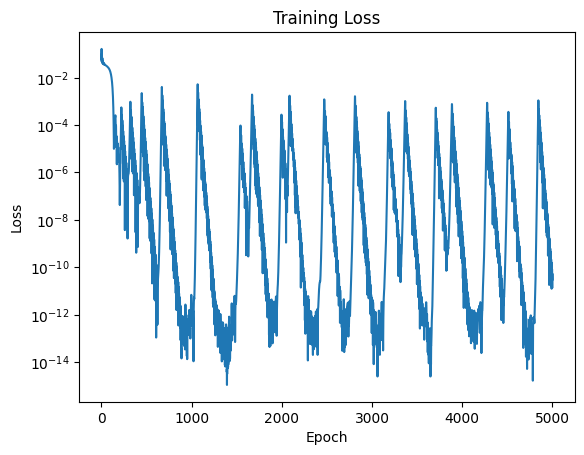

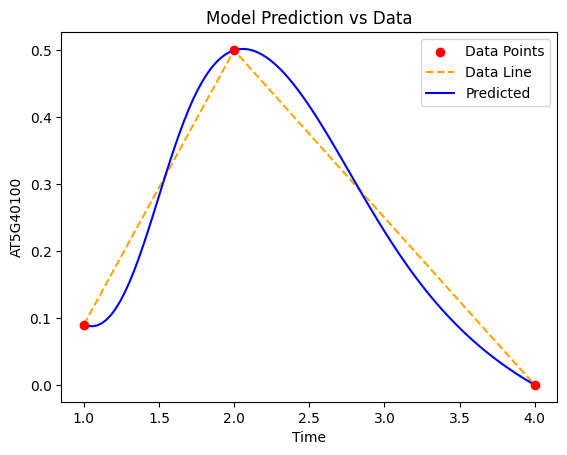

In [ ]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

# Given data
time_points = torch.tensor([1.0, 2.0, 4.0], dtype=torch.float32).view(-1, 1)
data_values = torch.tensor([.09, 0.5, 0.0], dtype=torch.float32).view(-1, 1)

# Neural Network for PINN
class PINN(nn.Module):
    def __init__(self):
        super(PINN, self).__init__()
        self.hidden = nn.Sequential(
            nn.Linear(1, 20),
            nn.Tanh(),
            nn.Linear(20, 20),
            nn.Tanh(),
            nn.Linear(20, 1)
        )
        # Parameters to estimate
        self.k = nn.Parameter(torch.tensor(0.1, requires_grad=True))
        self.c = nn.Parameter(torch.tensor(0.1, requires_grad=True))

    def forward(self, t):
        return self.hidden(t)

# Physics-Informed Loss Function
def loss_function(model, t, y_true):
    # Data loss
    y_pred = model(t)
    data_loss = torch.mean((y_pred - y_true) ** 2)

    # Physics loss
    # y_pred.requires_grad = True
    t = t.clone().requires_grad_(True)
    y_pred = model(t)
    dy_dt = torch.autograd.grad(y_pred, t, grad_outputs=torch.ones_like(y_pred), create_graph=True)[0]
    physics_loss = torch.mean((dy_dt + model.k * y_pred - model.c) ** 2)
    return data_loss + physics_loss

# Model, Optimizer, and Training Setup
model = PINN()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Training loop
num_epochs = 5000
loss_history = []
for epoch in range(num_epochs):
    optimizer.zero_grad()
    loss = loss_function(model, time_points, data_values)
    loss.backward()
    optimizer.step()

    loss_history.append(loss.item())
    if epoch % 500 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.6f}")

# Results
print("Estimated parameters:")
print(f"k: {model.k.item():.6f}, c: {model.c.item():.6f}")

# Plot Loss History
plt.plot(loss_history)
plt.yscale('log')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()

# Plot Prediction vs Data
# Plot given data points
plt.scatter(time_points.numpy(), data_values.numpy(), label='Data Points', color='red', zorder=5)
plt.plot(time_points.numpy(), data_values.numpy(), label='Data Line', color='orange', linestyle='--')

# Plot model prediction
t_fine = torch.linspace(1, 4, 100).view(-1, 1)
y_pred_fine = model(t_fine).detach().numpy()
plt.plot(t_fine.numpy(), y_pred_fine, label='Predicted', color='blue')

plt.xlabel('Time')
plt.ylabel('AT5G40100')
plt.title('Model Prediction vs Data')
plt.legend()
plt.show()


Epoch 0, Loss: 10.74763298034668
Epoch 1000, Loss: 2.6017059126114302e-14
Epoch 2000, Loss: 6.1233110595915186e-12
Epoch 3000, Loss: 3.067552323265943e-10
Epoch 4000, Loss: 6.677837518509477e-07
Epoch 5000, Loss: 2.4876021242903334e-09
Epoch 6000, Loss: 2.2133064703666605e-05
Epoch 7000, Loss: 0.0018473902018740773
Epoch 8000, Loss: 7.578569056931883e-05
Epoch 9000, Loss: 0.0005030608153901994
Learned k_p1: 0.6584514379501343
Learned k_d1: 0.7174445986747742
Learned k_d2: -9.316689101979136e-05


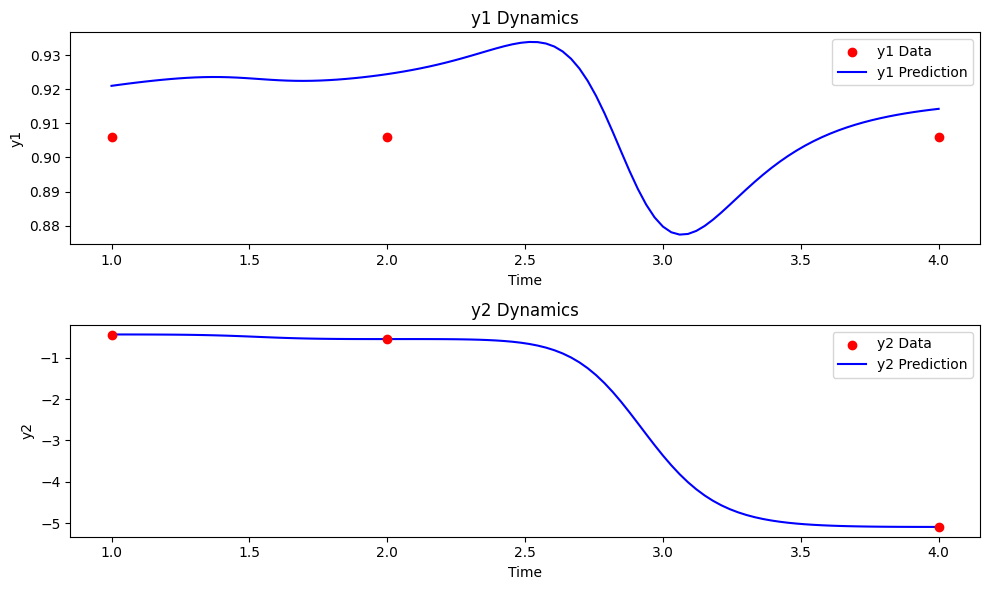

In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

# Define the neural network
class NeuralNet(nn.Module):
    def __init__(self):
        super(NeuralNet, self).__init__()
        self.hidden = nn.Sequential(
            nn.Linear(1, 50),
            nn.Tanh(),
            nn.Linear(50, 50),
            nn.Tanh(),
            nn.Linear(50, 2)  # Outputs: y1, y2
        )
        # Trainable parameters
        self.k_p1 = nn.Parameter(torch.tensor(1.0, requires_grad=True))
        self.k_d1 = nn.Parameter(torch.tensor(1.0, requires_grad=True))
        self.k_d2 = nn.Parameter(torch.tensor(1.0, requires_grad=True))

    def forward(self, t):
        return self.hidden(t)

# Define the ODE loss function
def loss_fn(model, t, y_data):
    y_pred = model(t)
    y1_pred, y2_pred = y_pred[:, 0], y_pred[:, 1]

    # Compute derivatives
    y1_t = torch.autograd.grad(y1_pred, t, grad_outputs=torch.ones_like(y1_pred), create_graph=True)[0]
    y2_t = torch.autograd.grad(y2_pred, t, grad_outputs=torch.ones_like(y2_pred), create_graph=True)[0]

    # ODE residuals
    ode1 = y1_t - (model.k_p1 - model.k_d1 * y1_pred)
    ode2 = y2_t + model.k_d2 * y2_pred

    # Physics loss
    physics_loss = torch.mean(ode1**2) + torch.mean(ode2**2)

    # Data loss
    data_loss = torch.mean((y1_pred - y_data[:, 0])**2) + torch.mean((y2_pred - y_data[:, 1])**2)

    return data_loss + 1.0 * physics_loss

# Generate data
t_data = torch.tensor([[1.0], [2.0], [4.0]], requires_grad=True)
y_data = torch.tensor([[0.906, -0.44796], [0.906, -0.56015], [0.906, -5.09196]])

# Initialize model and optimizer
model = NeuralNet()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Training loop
for epoch in range(10000):
    optimizer.zero_grad()
    loss = loss_fn(model, t_data, y_data)
    loss.backward()
    optimizer.step()
    if epoch % 1000 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item()}")

# Output learned parameters
print(f"Learned k_p1: {model.k_p1.item()}")
print(f"Learned k_d1: {model.k_d1.item()}")
print(f"Learned k_d2: {model.k_d2.item()}")

# Generate predictions for plotting
t_test = torch.linspace(1.0, 4.0, 100).view(-1, 1).requires_grad_(True)
y_pred = model(t_test).detach().numpy()

# Plotting the results
plt.figure(figsize=(10, 6))

# y1 Plot
plt.subplot(2, 1, 1)
plt.scatter(t_data.detach().numpy(), y_data[:, 0], color='red', label='y1 Data', zorder=5)
plt.plot(t_test.detach().numpy(), y_pred[:, 0], label='y1 Prediction', color='blue', zorder=4)
plt.title('y1 Dynamics')
plt.xlabel('Time')
plt.ylabel('y1')
plt.legend()

# y2 Plot
plt.subplot(2, 1, 2)
plt.scatter(t_data.detach().numpy(), y_data[:, 1], color='red', label='y2 Data', zorder=5)
plt.plot(t_test.detach().numpy(), y_pred[:, 1], label='y2 Prediction', color='blue', zorder=4)
plt.title('y2 Dynamics')
plt.xlabel('Time')
plt.ylabel('y2')
plt.legend()

plt.tight_layout()
plt.show()


Training for AT2G3847...
AT2G3847: Epoch 0, Loss: 1.8364969491958618
AT2G3847: Epoch 100, Loss: 0.0003032267850358039
AT2G3847: Epoch 200, Loss: 1.352309209323721e-05
AT2G3847: Epoch 300, Loss: 3.581479177228175e-06
AT2G3847: Epoch 400, Loss: 1.023955519485753e-06
AT2G3847: Epoch 500, Loss: 4.987925876775989e-07
AT2G3847: Epoch 600, Loss: 4.103758612927777e-07
AT2G3847: Epoch 700, Loss: 3.873932996611984e-07
AT2G3847: Epoch 800, Loss: 3.7072732084197924e-07
AT2G3847: Epoch 900, Loss: 3.5394074870964687e-07
AT2G3847: Learned k_p = 0.9054805040359497, k_d = 0.9992608428001404
Training for AT5G4010...
AT5G4010: Epoch 0, Loss: 9.721545219421387
AT5G4010: Epoch 100, Loss: 0.0033640777692198753
AT5G4010: Epoch 200, Loss: 8.656135719320446e-08
AT5G4010: Epoch 300, Loss: 2.2610062693634303e-12
AT5G4010: Epoch 400, Loss: 0.00014132633805274963
AT5G4010: Epoch 500, Loss: 2.7588824558222313e-09
AT5G4010: Epoch 600, Loss: 3.0947098182687593e-12
AT5G4010: Epoch 700, Loss: 1.5516476992161188e-12
AT5

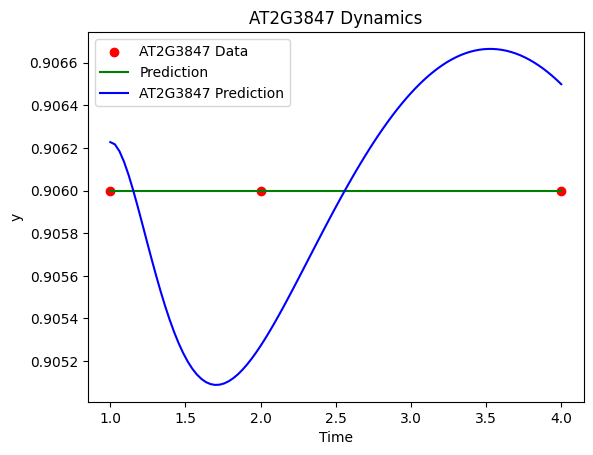

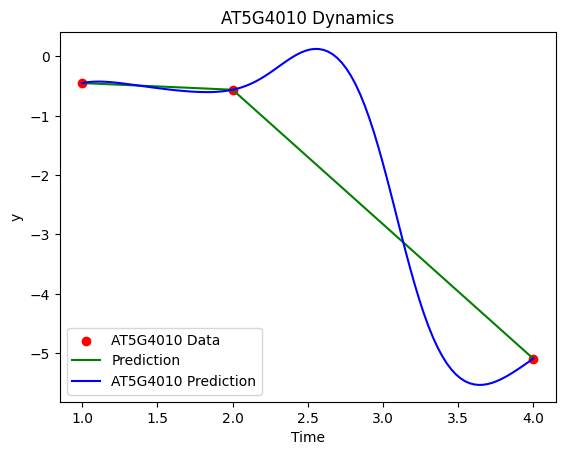

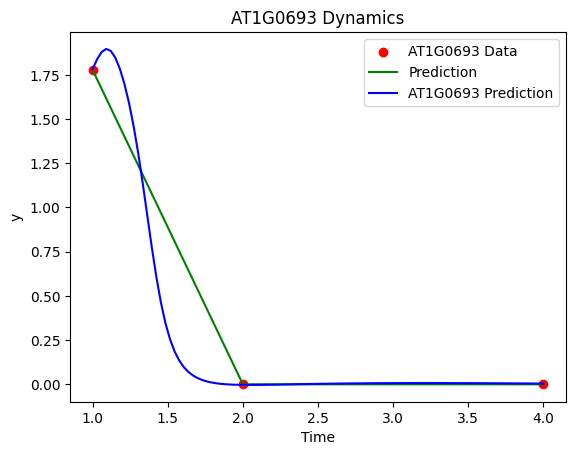

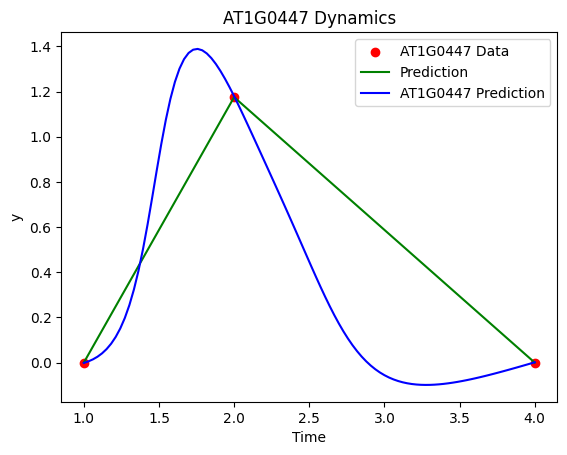

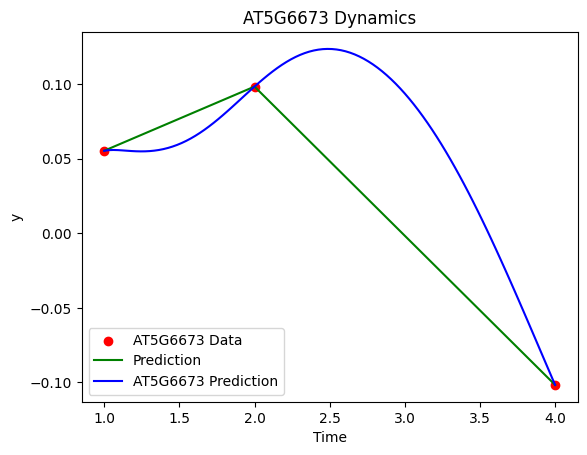

In [8]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

# Define the neural network
class NeuralNet(nn.Module):
    def __init__(self):
        super(NeuralNet, self).__init__()
        self.hidden = nn.Sequential(
            nn.Linear(1, 50),
            nn.Tanh(),
            nn.Linear(50, 50),
            nn.Tanh(),
            nn.Linear(50, 1)  # Output: y(t)
        )
        # Trainable parameters for the ODE
        self.k_p = nn.Parameter(torch.tensor(1.0, requires_grad=True))
        self.k_d = nn.Parameter(torch.tensor(1.0, requires_grad=True))

    def forward(self, t):
        return self.hidden(t)

# Define the ODE loss function
def loss_fn(model, t, y_data, ode_type="linear"):
    y_pred = model(t)
    y_t = torch.autograd.grad(y_pred, t, grad_outputs=torch.ones_like(y_pred), create_graph=True)[0]

    if ode_type == "linear":
        ode_residual = y_t - (model.k_p - model.k_d * y_pred)
    elif ode_type == "quadratic":
        ode_residual = y_t - model.k_p * y_pred**2
    elif ode_type == "sinusoidal":
        ode_residual = y_t - (model.k_p + model.k_d * torch.sin(y_pred))
    else:
        raise ValueError("Unsupported ODE type!")

    # Physics loss
    physics_loss = torch.mean(ode_residual**2)

    # Data loss
    data_loss = torch.mean((y_pred - y_data)**2)

    return data_loss + 1.0 * physics_loss

# Data preprocessing
t_data = torch.tensor([[1.0], [2.0], [4.0]], requires_grad=True)
dataset = {
    "AT2G3847": torch.tensor([0.906, 0.906, 0.906]),
    "AT5G4010": torch.tensor([-0.44796, -0.56015, -5.09196]),
    "AT1G0693": torch.tensor([1.778359, 0, 0]),
    "AT1G0447": torch.tensor([0, 1.17515, 0]),
    "AT5G6673": torch.tensor([0.055375, 0.098435, -0.101757])
}

ode_types = {
    "AT2G3847": "linear",
    "AT5G4010": "linear",
    "AT1G0693": "quadratic",
    "AT1G0447": "linear",
    "AT5G6673": "sinusoidal"
}

# Train models for each feature
models = {}
for feature, y_data in dataset.items():
    print(f"Training for {feature}...")
    y_data = y_data.view(-1, 1)  # Reshape data
    model = NeuralNet()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

    for epoch in range(1000):
        optimizer.zero_grad()
        loss = loss_fn(model, t_data, y_data, ode_types[feature])
        loss.backward()
        optimizer.step()
        if epoch % 100 == 0:
            print(f"{feature}: Epoch {epoch}, Loss: {loss.item()}")

    # Store the trained model
    models[feature] = model
    print(f"{feature}: Learned k_p = {model.k_p.item()}, k_d = {model.k_d.item()}")

# Plotting the results
for feature, y_data in dataset.items():
    model = models[feature]
    t_test = torch.linspace(1.0, 4.0, 100).view(-1, 1).requires_grad_(True)
    y_pred = model(t_test).detach().numpy()

    plt.figure()
    plt.scatter(t_data.detach().numpy(), y_data.numpy(), color='red', label=f'{feature} Data')
    plt.plot(t_data.detach().numpy(), y_data.detach().numpy(), label='Prediction', color='green')

    plt.plot(t_test.detach().numpy(), y_pred, label=f'{feature} Prediction', color='blue')

    plt.title(f'{feature} Dynamics')
    plt.xlabel('Time')
    plt.ylabel('y')
    plt.legend()
    plt.show()


Epoch 0, Loss: 9.893755912780762
Epoch 100, Loss: 0.02115190587937832
Epoch 200, Loss: 0.004460504744201899
Epoch 300, Loss: 0.0004033187869936228
Epoch 400, Loss: 1.4964901311032008e-05
Epoch 500, Loss: 6.898510946484748e-06
Epoch 600, Loss: 8.148482777414756e-09
Epoch 700, Loss: 4.392338576186816e-11
Epoch 800, Loss: 0.012503938749432564
Epoch 900, Loss: 5.26192081906629e-07
Learned k_p: 0.5058163404464722
Learned k_d: 0.7607607245445251


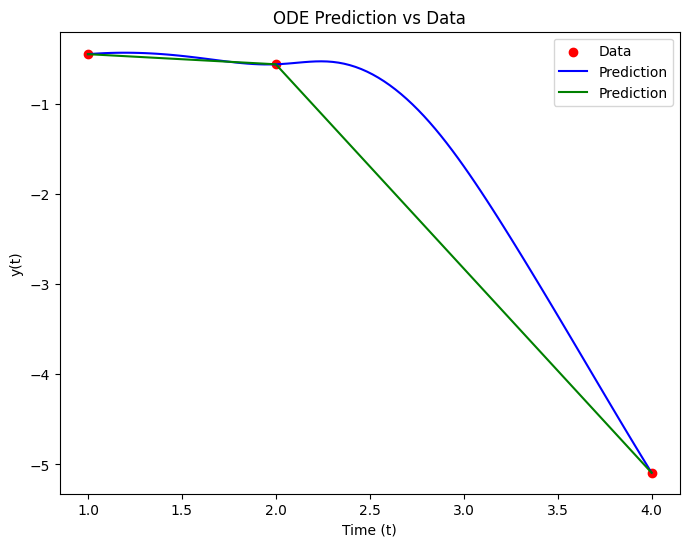

In [9]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

# Define the neural network
class NeuralNet(nn.Module):
    def __init__(self):
        super(NeuralNet, self).__init__()
        self.hidden = nn.Sequential(
            nn.Linear(1, 50),
            nn.Tanh(),
            nn.Linear(50, 50),
            nn.Tanh(),
            nn.Linear(50, 1)  # Output: y(t)
        )
        # Trainable parameters for the ODE
        self.k_p = nn.Parameter(torch.tensor(1.0, requires_grad=True))  # Forcing term
        self.k_d = nn.Parameter(torch.tensor(1.0, requires_grad=True))  # Decay/growth rate

    def forward(self, t):
        return self.hidden(t)

# Define the ODE loss function
def loss_fn(model, t, y_data):
    y_pred = model(t)
    y_t = torch.autograd.grad(y_pred, t, grad_outputs=torch.ones_like(y_pred), create_graph=True)[0]

    # ODE residual
    ode_residual = y_t - (model.k_p + model.k_d * y_pred)

    # Physics loss
    physics_loss = torch.mean(ode_residual**2)

    # Data loss
    data_loss = torch.mean((y_pred - y_data)**2)

    return data_loss + 1.0 * physics_loss

# Data preprocessing
t_data = torch.tensor([[1.0], [2.0], [4.0]], requires_grad=True)  # Time points
y_data = torch.tensor([[-0.44796], [-0.56015], [-5.09196]])      # Corresponding values

# Initialize the model and optimizer
model = NeuralNet()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Training loop
for epoch in range(1000):
    optimizer.zero_grad()
    loss = loss_fn(model, t_data, y_data)
    loss.backward()
    optimizer.step()
    if epoch % 100 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item()}")

# Output the learned parameters
print(f"Learned k_p: {model.k_p.item()}")
print(f"Learned k_d: {model.k_d.item()}")

# Plotting the data and the prediction
t_test = torch.linspace(1.0, 4.0, 100).view(-1, 1).requires_grad_(True)
y_pred = model(t_test).detach().numpy()

plt.figure(figsize=(8, 6))
plt.scatter(t_data.detach().numpy(), y_data.numpy(), color='red', label='Data')
plt.plot(t_test.detach().numpy(), y_pred, label='Prediction', color='blue')
plt.plot(t_data.detach().numpy(), y_data.detach().numpy(), label='Prediction', color='green')


plt.title('ODE Prediction vs Data')
plt.xlabel('Time (t)')
plt.ylabel('y(t)')
plt.legend()
plt.show()


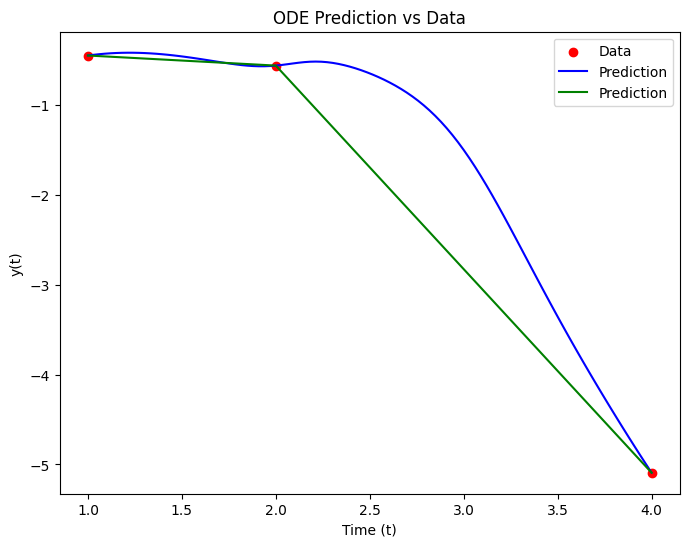

In [7]:
plt.figure(figsize=(8, 6))
plt.scatter(t_data.detach().numpy(), y_data.numpy(), color='red', label='Data')
plt.plot(t_test.detach().numpy(), y_pred, label='Prediction', color='blue')
plt.plot(t_data.detach().numpy(), y_data.detach().numpy(), label='Prediction', color='green')

plt.title('ODE Prediction vs Data')
plt.xlabel('Time (t)')
plt.ylabel('y(t)')
plt.legend()
plt.show()


Epoch 0, Loss: 4.38012170791626
Epoch 100, Loss: 0.3038289248943329
Epoch 200, Loss: 0.0642821341753006
Epoch 300, Loss: 0.008396816439926624
Epoch 400, Loss: 0.0004783803888130933
Epoch 500, Loss: 6.205088084243471e-06
Epoch 600, Loss: 7.446281102829744e-08
Epoch 700, Loss: 4.823873522852296e-10
Epoch 800, Loss: 3.692721128878418e-10
Epoch 900, Loss: 2.3485040401283186e-06
ODE 1: Learned k_p = 0.3294522762298584, k_d = -1.5040754419715086e-07
ODE 2: Learned k_p = 0.32945239543914795, k_d = -3.617098087715931e-08
ODE 3: Learned k_p = 0.3294529616832733, k_d = -8.642481361675891e-07


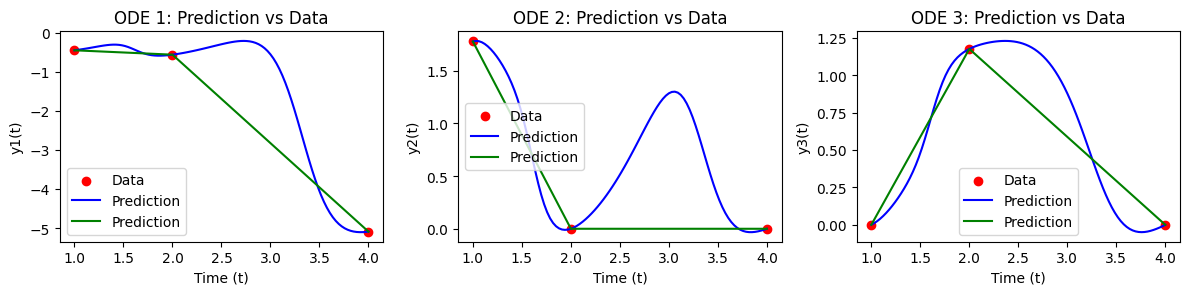

In [65]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

# Define the neural network
class NeuralNet(nn.Module):
    def __init__(self, num_odes):
        super(NeuralNet, self).__init__()
        self.hidden = nn.Sequential(
            nn.Linear(1, 50),
            nn.Tanh(),
            nn.Linear(50, 50),
            nn.Tanh(),
            nn.Linear(50, num_odes)  # Output: y1(t), y2(t), ..., yn(t)
        )
        # Trainable parameters for each ODE
        self.k_p = nn.Parameter(torch.ones(num_odes))  # Forcing terms
        self.k_d = nn.Parameter(torch.ones(num_odes))  # Decay/growth rates

    def forward(self, t):
        return self.hidden(t)

# Define the ODE loss function
def loss_fn(model, t, y_data, num_odes):
    y_pred = model(t)

    # Compute derivatives
    y_t = []
    for i in range(num_odes):
        grad = torch.autograd.grad(
            y_pred[:, i], t, grad_outputs=torch.ones_like(y_pred[:, i]), create_graph=True
        )[0]
        y_t.append(grad)
    y_t = torch.stack(y_t, dim=1)

    # ODE residuals for each ODE
    ode_residuals = y_t - (model.k_p + model.k_d * y_pred)
    physics_loss = torch.mean(ode_residuals**2)

    # Data loss
    data_loss = torch.mean((y_pred - y_data)**2)

    return data_loss + 1.0 * physics_loss

# Data preprocessing
t_data = torch.tensor([[1.0], [2.0], [4.0]], requires_grad=True)  # Time points
y_data = torch.tensor([
    [-0.44796003, 1.778358524, 0 ],
    [-0.560154646, 0, 1.175149691],
    [-5.091964284, 0, 0]
])  # Corresponding values (time-series for multiple ODEs)

num_odes = y_data.shape[1]

# Initialize the model and optimizer
model = NeuralNet(num_odes=num_odes)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Training loop
for epoch in range(1000):
    optimizer.zero_grad()
    loss = loss_fn(model, t_data, y_data, num_odes)
    loss.backward()
    optimizer.step()
    if epoch % 100 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item()}")

# Output the learned parameters
for i in range(num_odes):
    print(f"ODE {i+1}: Learned k_p = {model.k_p[i].item()}, k_d = {model.k_d[i].item()}")

# Plotting the data and predictions for each ODE
t_test = torch.linspace(1.0, 4.0, 100).view(-1, 1).requires_grad_(True)
y_pred = model(t_test).detach().numpy()

plt.figure(figsize=(12, 8))
for i in range(num_odes):
    plt.subplot(3, 3, i + 1)
    plt.scatter(t_data.detach().numpy(), y_data[:, i].numpy(), color='red', label='Data')
    plt.plot(t_test.detach().numpy(), y_pred[:, i], label='Prediction', color='blue')
    plt.plot(t_data.detach().numpy(), y_data[:, i], label='Prediction', color='green')

    plt.title(f'ODE {i+1}: Prediction vs Data')
    plt.xlabel('Time (t)')
    plt.ylabel(f'y{i+1}(t)')
    plt.legend()

plt.tight_layout()
plt.show()


Epoch 0, Loss: 19.54416847229004
Epoch 100, Loss: 0.881253182888031
Epoch 200, Loss: 0.04671427980065346
Epoch 300, Loss: 0.02309534326195717
Epoch 400, Loss: 0.007826549001038074
Epoch 500, Loss: 0.004833920393139124
Epoch 600, Loss: 0.010781574994325638
Epoch 700, Loss: 0.00452297693118453
Epoch 800, Loss: 0.004324661567807198
Epoch 900, Loss: 0.00408197334036231
ODE 1: Learned k_p: 0.3673902750015259, Learned k_d: -4.192330379737541e-06
ODE 2: Learned k_p: 0.2249705195426941, Learned k_d: 1.3780877452518325e-05
ODE 3: Learned k_p: 0.4433222711086273, Learned k_d: -8.09541052149143e-06
ODE 4: Learned k_p: 0.37807703018188477, Learned k_d: 1.0021735429763794
ODE 5: Learned k_p: 0.3153820335865021, Learned k_d: 0.46743044257164
ODE 6: Learned k_p: 0.3004360496997833, Learned k_d: 8.95168341230601e-06
ODE 7: Learned k_p: 0.3318425118923187, Learned k_d: 0.34486353397369385
ODE 8: Learned k_p: 0.37765416502952576, Learned k_d: 0.00011526555317686871
ODE 9: Learned k_p: 0.3324058353900909

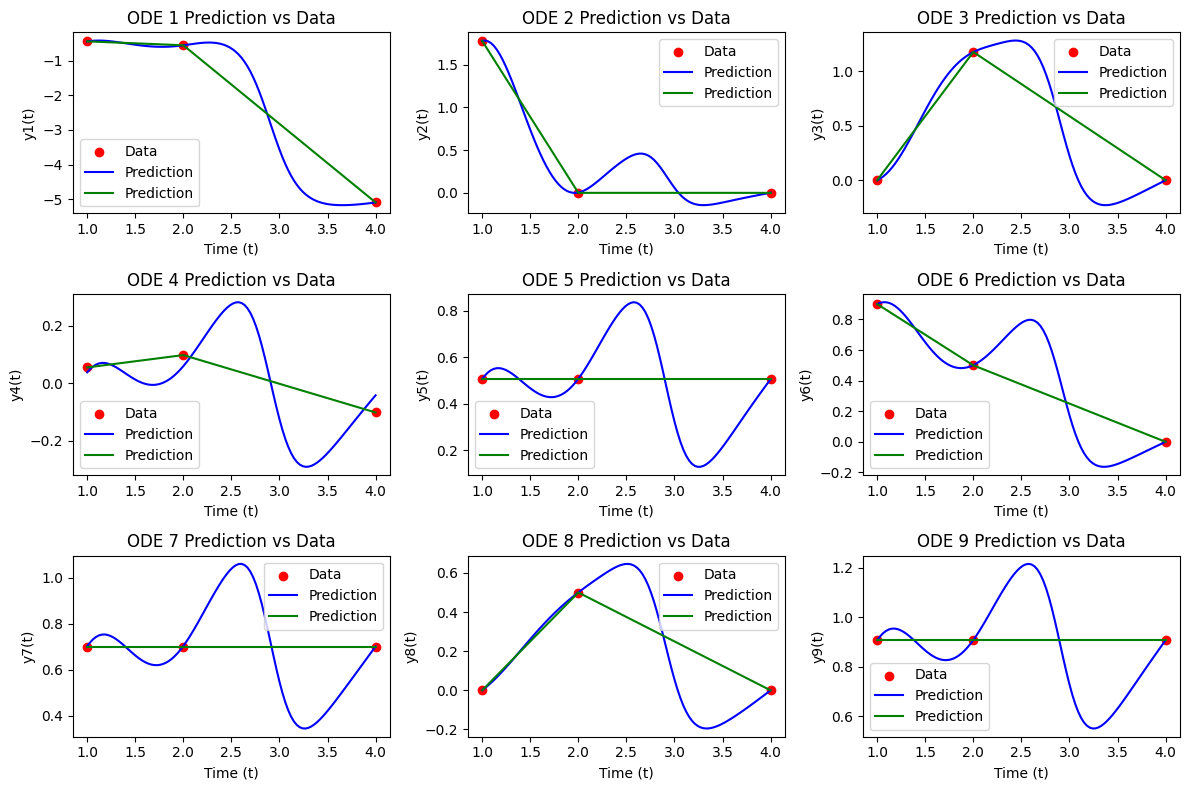

In [66]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

# Define the neural network
class NeuralNet(nn.Module):
    def __init__(self, num_odes):
        super(NeuralNet, self).__init__()
        self.hidden = nn.Sequential(
            nn.Linear(1, 50),
            nn.Tanh(),
            nn.Linear(50, 50),
            nn.Tanh(),
            nn.Linear(50, num_odes)  # Output: y(t) for each ODE
        )
        # Trainable parameters for each ODE
        self.k_p = nn.Parameter(torch.ones(num_odes))  # Forcing terms
        self.k_d = nn.Parameter(torch.ones(num_odes))  # Decay/growth rates

    def forward(self, t):
        return self.hidden(t)

# Define the ODE loss function
def loss_fn(model, t, y_data):
    y_pred = model(t)  # Predicted outputs (all ODEs)
    num_odes = y_data.shape[1]

    # Compute derivatives and ODE residuals
    losses = []
    for i in range(num_odes):
        y_i_pred = y_pred[:, i]
        y_i_t = torch.autograd.grad(
            y_i_pred, t, grad_outputs=torch.ones_like(y_i_pred), create_graph=True
        )[0]
        # ODE residual for the i-th ODE
        ode_residual = y_i_t - (model.k_p[i] + model.k_d[i] * y_i_pred)

        # Physics loss
        physics_loss = torch.mean(ode_residual**2)

        # Data loss
        data_loss = torch.mean((y_i_pred - y_data[:, i])**2)

        # Total loss for the i-th ODE
        losses.append(data_loss + 1.0 * physics_loss)

    # Sum losses for all ODEs
    return sum(losses)

# Data preprocessing
# Define time points (t_data) and the data matrix (y_data)
t_data = torch.tensor([[1.0], [2.0], [4.0]], requires_grad=True)  # Time points
y_data = torch.tensor([
    [-0.44796, -0.56015, -5.09196],
    [1.77836, 0.0, 0.0],
    [0.0, 1.17515, 0.0],
    [0.05537, 0.09843, -0.10176],
    [0.505, 0.505, 0.505],
    [0.9, 0.5, 0.0],
    [0.7, 0.7, 0.7],
    [0.0, 0.5, 0.0],
    [0.906, 0.906, 0.906]
]).T  # Transpose to have columns for ODEs

# Initialize the model and optimizer
num_odes = y_data.shape[1]
model = NeuralNet(num_odes)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Training loop
for epoch in range(1000):
    optimizer.zero_grad()
    loss = loss_fn(model, t_data, y_data)
    loss.backward()
    optimizer.step()
    if epoch % 100 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item()}")

# Output the learned parameters
for i in range(num_odes):
    print(f"ODE {i+1}: Learned k_p: {model.k_p[i].item()}, Learned k_d: {model.k_d[i].item()}")

# Plotting the data and the prediction for each ODE
t_test = torch.linspace(1.0, 4.0, 100).view(-1, 1).requires_grad_(True)
y_pred = model(t_test).detach().numpy()

plt.figure(figsize=(12, 8))
for i in range(num_odes):
    plt.subplot(3, 3, i+1)  # Create a subplot for each ODE
    plt.scatter(t_data.detach().numpy(), y_data[:, i].numpy(), color='red', label='Data')
    plt.plot(t_test.detach().numpy(), y_pred[:, i], label='Prediction', color='blue')
    plt.plot(t_data.detach().numpy(), y_data[:, i], label='Prediction', color='green')

    plt.title(f'ODE {i+1} Prediction vs Data')
    plt.xlabel('Time (t)')
    plt.ylabel(f'y{i+1}(t)')
    plt.legend()

plt.tight_layout()
plt.show()
